In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk.stem.snowball import SnowballStemmer
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
from google.colab import drive
import os

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import os

path = '/content/drive/My Drive/text.csv'
df = pd.read_csv(path)

In [4]:
df.head(10)

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4
5,5,i was beginning to feel quite disheartened,0
6,6,i would think that whomever would be lucky eno...,2
7,7,i fear that they won t ever feel that deliciou...,1
8,8,im forever taking some time out to have a lie ...,5
9,9,i can still lose the weight without feeling de...,0


In [4]:
df.columns

Index(['Unnamed: 0', 'text', 'label'], dtype='object')

In [5]:
df.drop(columns='Unnamed: 0', inplace=True)

In [6]:
print(f'The Shape Of Data Is : {df.shape}')

The Shape Of Data Is : (416809, 2)


In [7]:
# checking the duplicates we have found some so we are going to remove them
df.duplicated().sum()

686

In [8]:
# removing the duplicates
df = df.drop_duplicates()

In [9]:
# rechecking the duplicates
df.duplicated().sum()

0

data cleaning

In [10]:
emotion_map = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
    # Add more mappings as needed
}

df['label'] = df['label'].map(emotion_map)

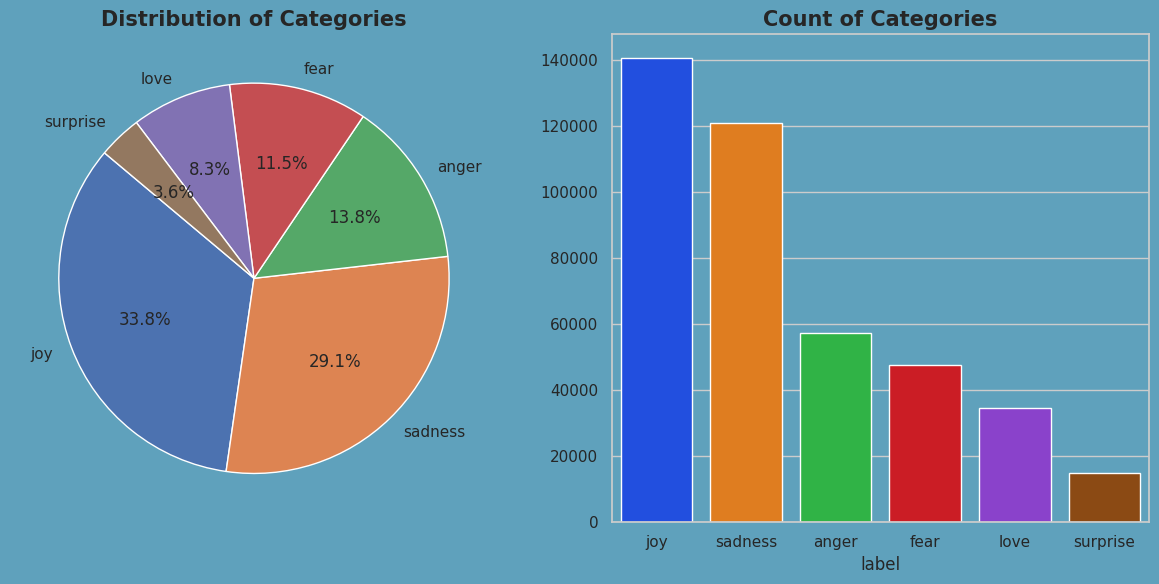

In [11]:
count = df['label'].value_counts()

# Set the background color and theme
background_color = '#5fa1bc'
sns.set_theme(style="whitegrid", rc={"axes.facecolor": background_color, 'figure.facecolor': background_color})

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor=background_color)

# Plot pie chart on the first subplot
palette = sns.color_palette("bright", len(count))
sns.set_palette(palette)
axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Distribution of Categories', fontsize=15, fontweight='bold')

# Plot bar chart on the second subplot
sns.barplot(x=count.index, y=count.values, ax=axs[1], palette=palette)
axs[1].set_title('Count of Categories', fontsize=15, fontweight='bold')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

1. chat words

In [12]:
chat_words = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "B4N": "Bye For Now",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "ILU: I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA?": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laugher",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don't care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "BFF": "Best friends forever",
    "CSL": "Can't stop laughing"
}

In [13]:
def replace_chat_words(text):
    words = text.split()
    for i, word in enumerate(words):
        if word.lower() in chat_words:
            words[i] = chat_words[word.lower()]
    return ' '.join(words)

# Apply replace_chat_words function to 'Text' column
df['text'] = df['text'].apply(replace_chat_words)

2. non alpha numeric characters

In [14]:
df['text'] = df['text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

df.head()

,text,label
0,i just feel really helpless and heavy hearted,fear
1,ive enjoyed being able to slouch about relax a...,sadness
2,i gave up my internship with the dmrg and am f...,fear
3,i dont know i feel so lost,sadness
4,i am a kindergarten teacher and i am thoroughl...,fear


3. stop words

In [15]:
stop = stopwords.words('english')
df["text"] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df['text'] = df['text'].str.lower()

df.head()

,text,label
0,feel really helpless heavy hearted,fear
1,ive enjoyed able slouch relax unwind frankly n...,sadness
2,gave internship dmrg feeling distraught,fear
3,dont know feel lost,sadness
4,kindergarten teacher thoroughly weary job take...,fear


4. removing numeric/white space/special character/urls

In [16]:
df['text'] = df['text'].str.replace(r'\d+', '', regex=True)
df['text'] = df['text'].str.replace(r'\s+', ' ', regex=True)
df['text'] = df['text'].str.replace(r'[^\w\s]', '', regex=True)
df['text'] = df['text'].str.replace(r'http\S+', '', regex=True)
df.head()

,text,label
0,feel really helpless heavy hearted,fear
1,ive enjoyed able slouch relax unwind frankly n...,sadness
2,gave internship dmrg feeling distraught,fear
3,dont know feel lost,sadness
4,kindergarten teacher thoroughly weary job take...,fear


visualization

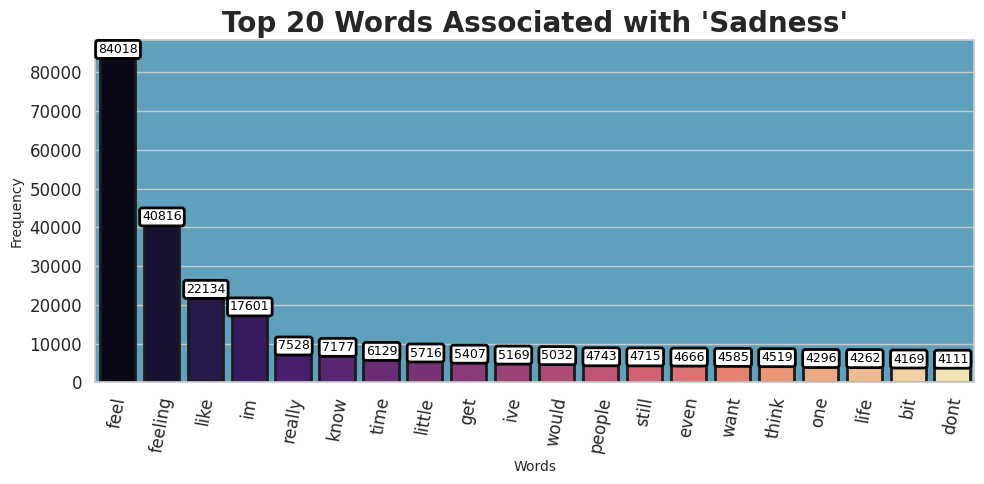

In [ ]:
love_texts = df[df['label'] == 'sadness']['text']

# Tokenize the text and count the frequency of each word
words = [word.lower() for text in love_texts for word in word_tokenize(text)]
word_freq = Counter(words)

# Get the top 20 words
top_20_words = dict(word_freq.most_common(20))

# Set the background color and theme
background_color = '#5fa1bc'
sns.set_theme(style="whitegrid", rc={"axes.facecolor": background_color})

# Create a bar plot
plt.figure(figsize=(10, 5))
p = sns.barplot(x=list(top_20_words.keys()), y=list(top_20_words.values()), palette='magma', edgecolor='#1c1c1c', linewidth=2)
for container in p.containers:
    plt.bar_label(container, label_type="edge", color="black", fontsize=9, padding=6, position=(0.5, 0.5),
                  bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "white", "edgecolor": "black", "linewidth": 2, "alpha": 1})
plt.title("Top 20 Words Associated with 'Sadness'", fontsize=20, fontweight='bold')
plt.xlabel("Words", fontsize=10 )
plt.ylabel("Frequency", fontsize=10)
plt.xticks(rotation=80, fontsize=12,)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

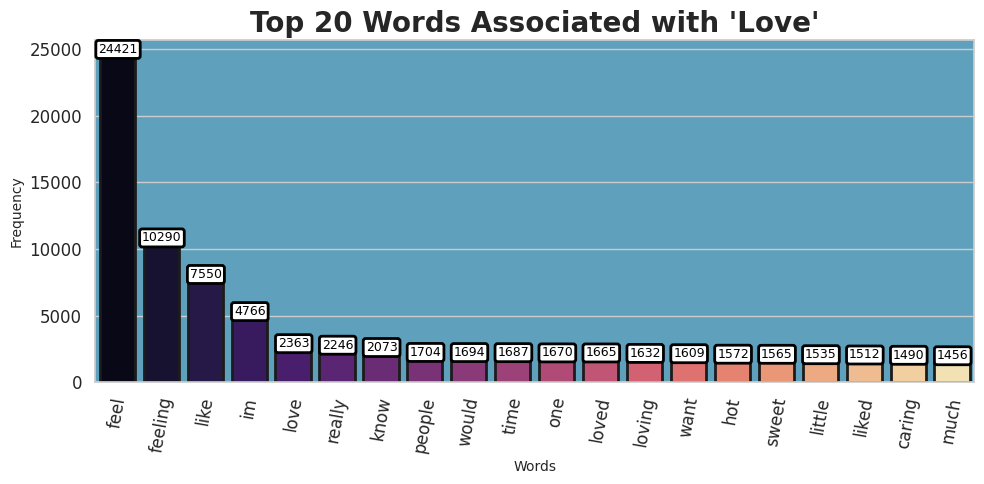

In [ ]:
love_texts = df[df['label'] == 'love']['text']

# Tokenize the text and count the frequency of each word
words = [word.lower() for text in love_texts for word in word_tokenize(text)]
word_freq = Counter(words)

# Get the top 20 words
top_20_words = dict(word_freq.most_common(20))

# Set the background color and theme
background_color = '#5fa1bc'
sns.set_theme(style="whitegrid", rc={"axes.facecolor": background_color})
# Create a bar plot
plt.figure(figsize=(10, 5))
p = sns.barplot(x=list(top_20_words.keys()), y=list(top_20_words.values()), palette='magma', edgecolor='#1c1c1c', linewidth=2)
for container in p.containers:
    plt.bar_label(container, label_type="edge", color="black", fontsize=9, padding=6, position=(0.5, 0.5),
                  bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "white", "edgecolor": "black", "linewidth": 2, "alpha": 1})
plt.title("Top 20 Words Associated with 'Love'", fontsize=20, fontweight='bold')
plt.xlabel("Words", fontsize=10 )
plt.ylabel("Frequency", fontsize=10)
plt.xticks(rotation=80, fontsize=12,)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

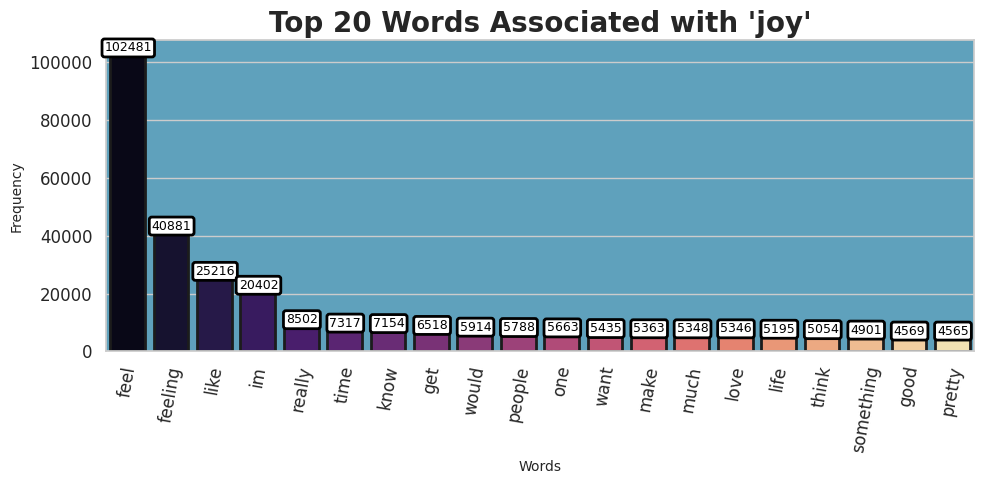

In [ ]:
love_texts = df[df['label'] == 'joy']['text']

# Tokenize the text and count the frequency of each word
words = [word.lower() for text in love_texts for word in word_tokenize(text)]
word_freq = Counter(words)

# Get the top 20 words
top_20_words = dict(word_freq.most_common(20))

# Set the background color and theme
background_color = '#5fa1bc'
sns.set_theme(style="whitegrid", rc={"axes.facecolor": background_color})

# Create a bar plot
plt.figure(figsize=(10, 5))
p = sns.barplot(x=list(top_20_words.keys()), y=list(top_20_words.values()), palette='magma', edgecolor='#1c1c1c', linewidth=2)
for container in p.containers:
    plt.bar_label(container, label_type="edge", color="black", fontsize=9, padding=6, position=(0.5, 0.5),
                  bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "white", "edgecolor": "black", "linewidth": 2, "alpha": 1})
plt.title("Top 20 Words Associated with 'joy'", fontsize=20, fontweight='bold')
plt.xlabel("Words", fontsize=10 )
plt.ylabel("Frequency", fontsize=10)
plt.xticks(rotation=80, fontsize=12,)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

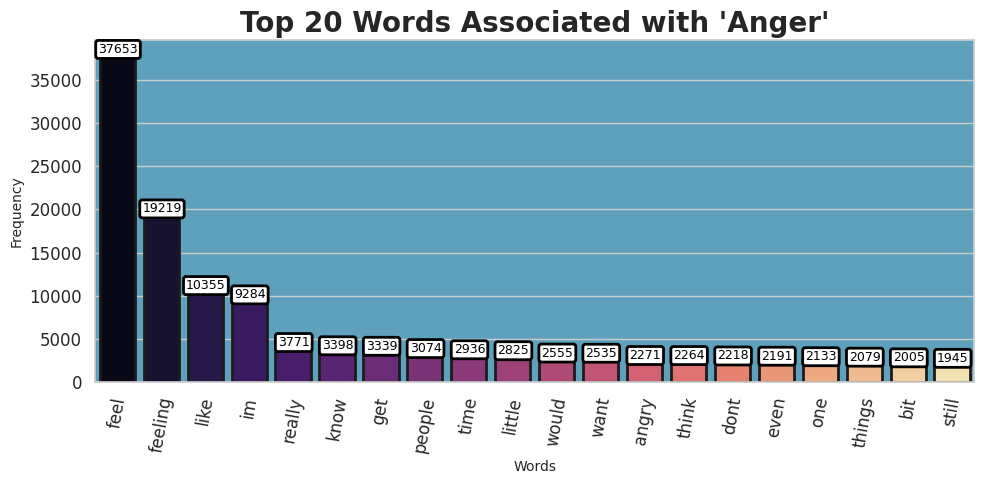

In [ ]:
love_texts = df[df['label'] == 'anger']['text']

# Tokenize the text and count the frequency of each word
words = [word.lower() for text in love_texts for word in word_tokenize(text)]
word_freq = Counter(words)

# Get the top 20 words
top_20_words = dict(word_freq.most_common(20))

# Set the background color and theme
background_color = '#5fa1bc'
sns.set_theme(style="whitegrid", rc={"axes.facecolor": background_color})

# Create a bar plot
plt.figure(figsize=(10, 5))
p = sns.barplot(x=list(top_20_words.keys()), y=list(top_20_words.values()), palette='magma', edgecolor='#1c1c1c', linewidth=2)
for container in p.containers:
    plt.bar_label(container, label_type="edge", color="black", fontsize=9, padding=6, position=(0.5, 0.5),
                  bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "white", "edgecolor": "black", "linewidth": 2, "alpha": 1})
plt.title("Top 20 Words Associated with 'Anger'", fontsize=20, fontweight='bold')
plt.xlabel("Words", fontsize=10 )
plt.ylabel("Frequency", fontsize=10)
plt.xticks(rotation=80, fontsize=12,)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

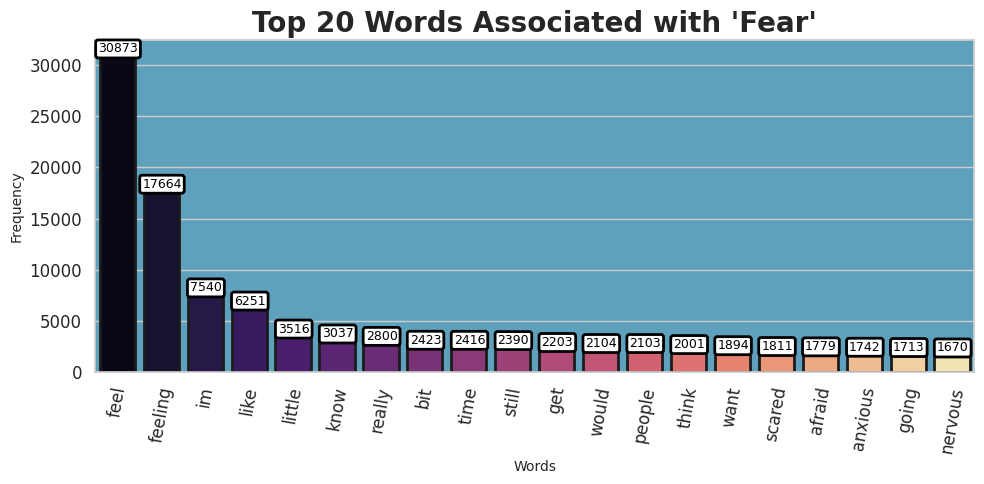

In [ ]:
love_texts = df[df['label'] == 'fear']['text']

# Tokenize the text and count the frequency of each word
words = [word.lower() for text in love_texts for word in word_tokenize(text)]
word_freq = Counter(words)

# Get the top 20 words
top_20_words = dict(word_freq.most_common(20))

# Set the background color and theme
background_color = '#5fa1bc'
sns.set_theme(style="whitegrid", rc={"axes.facecolor": background_color})

# Create a bar plot
plt.figure(figsize=(10, 5))
p = sns.barplot(x=list(top_20_words.keys()), y=list(top_20_words.values()), palette='magma', edgecolor='#1c1c1c', linewidth=2)
for container in p.containers:
    plt.bar_label(container, label_type="edge", color="black", fontsize=9, padding=6, position=(0.5, 0.5),
                  bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "white", "edgecolor": "black", "linewidth": 2, "alpha": 1})
plt.title("Top 20 Words Associated with 'Fear'", fontsize=20, fontweight='bold')
plt.xlabel("Words", fontsize=10 )
plt.ylabel("Frequency", fontsize=10)
plt.xticks(rotation=80, fontsize=12,)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

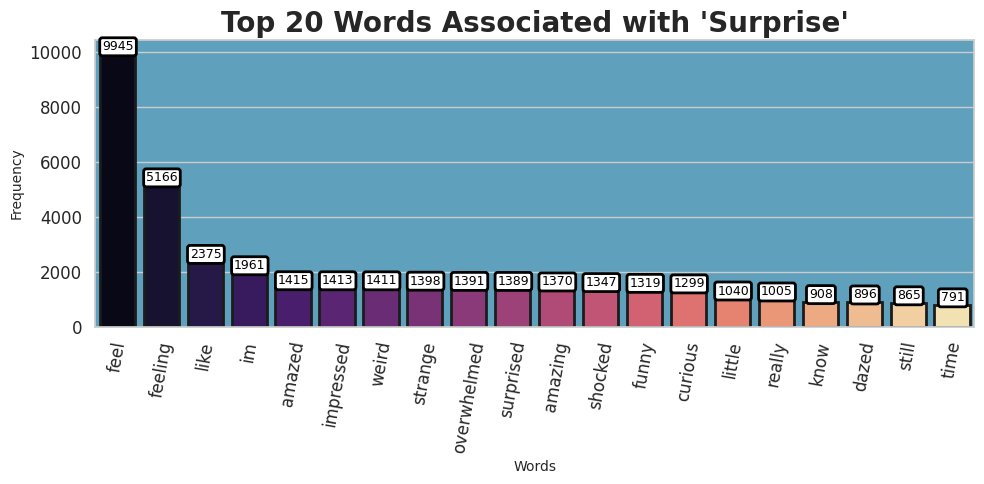

In [ ]:
love_texts = df[df['label'] == 'surprise']['text']

# Tokenize the text and count the frequency of each word
words = [word.lower() for text in love_texts for word in word_tokenize(text)]
word_freq = Counter(words)

# Get the top 20 words
top_20_words = dict(word_freq.most_common(20))

# Set the background color and themesss
background_color = '#5fa1bc'
sns.set_theme(style="whitegrid", rc={"axes.facecolor": background_color})

# Create a bar plot
plt.figure(figsize=(10, 5))
p = sns.barplot(x=list(top_20_words.keys()), y=list(top_20_words.values()), palette='magma', edgecolor='#1c1c1c', linewidth=2)
for container in p.containers:
    plt.bar_label(container, label_type="edge", color="black", fontsize=9, padding=6, position=(0.5, 0.5),
                  bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "white", "edgecolor": "black", "linewidth": 2, "alpha": 1})
plt.title("Top 20 Words Associated with 'Surprise'", fontsize=20, fontweight='bold')
plt.xlabel("Words", fontsize=10 )
plt.ylabel("Frequency", fontsize=10)
plt.xticks(rotation=80, fontsize=12,)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

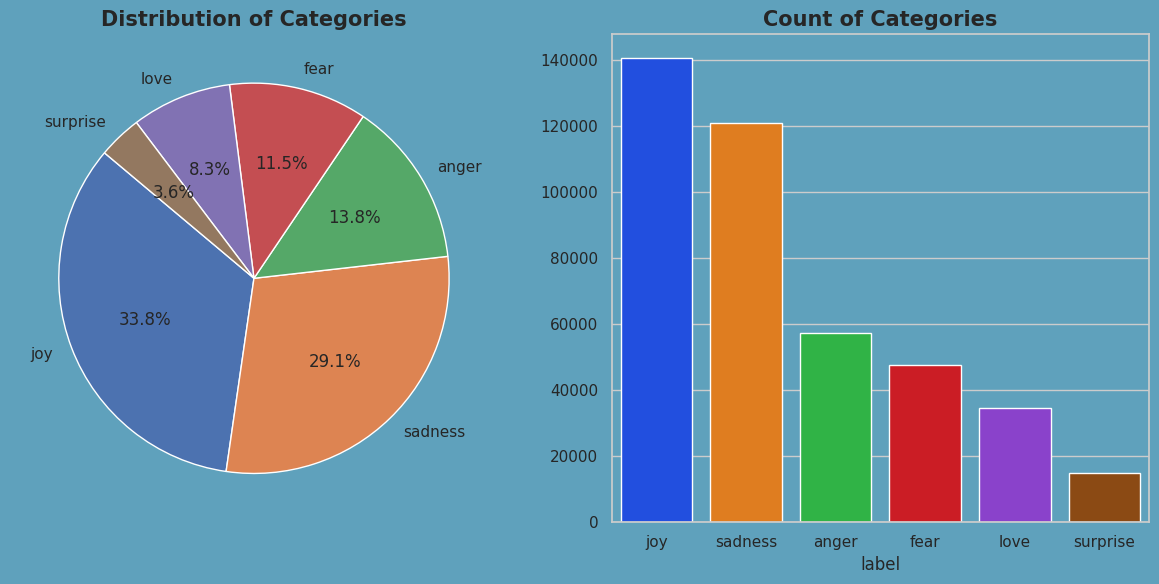

In [ ]:
count = df['label'].value_counts()

# Set the background color and theme
background_color = '#5fa1bc'
sns.set_theme(style="whitegrid", rc={"axes.facecolor": background_color, 'figure.facecolor': background_color})

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor=background_color)

# Plot pie chart on the first subplot
palette = sns.color_palette("bright", len(count))
sns.set_palette(palette)
axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Distribution of Categories', fontsize=15, fontweight='bold')

# Plot bar chart on the second subplot
sns.barplot(x=count.index, y=count.values, ax=axs[1], palette=palette)
axs[1].set_title('Count of Categories', fontsize=15, fontweight='bold')

# Adjust layout
plt.tight_layout()
plt.show()

In [17]:
df.head()

,text,label
0,feel really helpless heavy hearted,fear
1,ive enjoyed able slouch relax unwind frankly n...,sadness
2,gave internship dmrg feeling distraught,fear
3,dont know feel lost,sadness
4,kindergarten teacher thoroughly weary job take...,fear


In [18]:
# Define a mapping dictionary
label_mapping = {'sadness':0, 'joy':1, 'love':2, 'anger':3, 'fear':4,'surprise':5}

# Rename the 'Label' column using the mapping dictionary
df['label'] = df['label'].map(label_mapping)

In [19]:
df.head()

,text,label
0,feel really helpless heavy hearted,4
1,ive enjoyed able slouch relax unwind frankly n...,0
2,gave internship dmrg feeling distraught,4
3,dont know feel lost,0
4,kindergarten teacher thoroughly weary job take...,4


train

In [34]:
from sklearn.model_selection import train_test_split

X = df['text']
y = df['label']

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Print the shapes of the training and testing sets
print("The shape of X_train is ", X_train.shape)
print("The shape of X_test is ", X_test.shape)
print("The shape of y_train is", y_train.shape)
print("The shape of y_test is", y_test.shape)

The shape of X_train is  (332898,)
The shape of X_test is  (83225,)
The shape of y_train is (332898,)
The shape of y_test is (83225,)


bert

In [20]:
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import Adam
import torch

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts.reset_index(drop=True)  # Reset index to ensure continuity
        self.labels = labels.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        inputs = self.tokenizer(text, max_length=self.max_len, padding='max_length', truncation=True, return_tensors="pt")
        input_ids = inputs['input_ids'].squeeze(0)
        attention_mask = inputs['attention_mask'].squeeze(0)

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': torch.tensor(label, dtype=torch.long)
        }


from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)

train_dataset = TextDataset(X_train, y_train, tokenizer=tokenizer, max_len=79)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = TextDataset(X_test, y_test, tokenizer=tokenizer, max_len=79)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [21]:
from transformers import BertForSequenceClassification, AdamW

model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=6)
optimizer = AdamW(model.parameters(), lr=2e-5)  # You can adjust learning rate

# If you are using a GPU, move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [22]:
from torch.nn import CrossEntropyLoss
from tqdm import tqdm
import torch

def train_model(model, dataloader, optimizer, device, epochs):
    model.train()  # Set the model to training mode
    epoch_losses = []
    epoch_accuracies = []

    for epoch in range(epochs):
        total_loss = 0
        total_correct = 0
        total_samples = 0

        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch + 1}/{epochs}", leave=True)
        for batch in progress_bar:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            correct = torch.sum(predictions == labels).item()
            total_correct += correct
            total_samples += labels.size(0)

            progress_bar.set_postfix({'loss': loss.item(), 'accuracy': f"{100 * correct / labels.size(0):.2f}%"})

        average_loss = total_loss / len(dataloader)
        overall_accuracy = 100 * total_correct / total_samples
        epoch_losses.append(average_loss)
        epoch_accuracies.append(overall_accuracy)

    return epoch_losses, epoch_accuracies


Epoch 5/5: 100%|██████████| 20807/20807 [13:54<00:00, 24.92it/s, loss=2.28e-5, accuracy=100.00%]


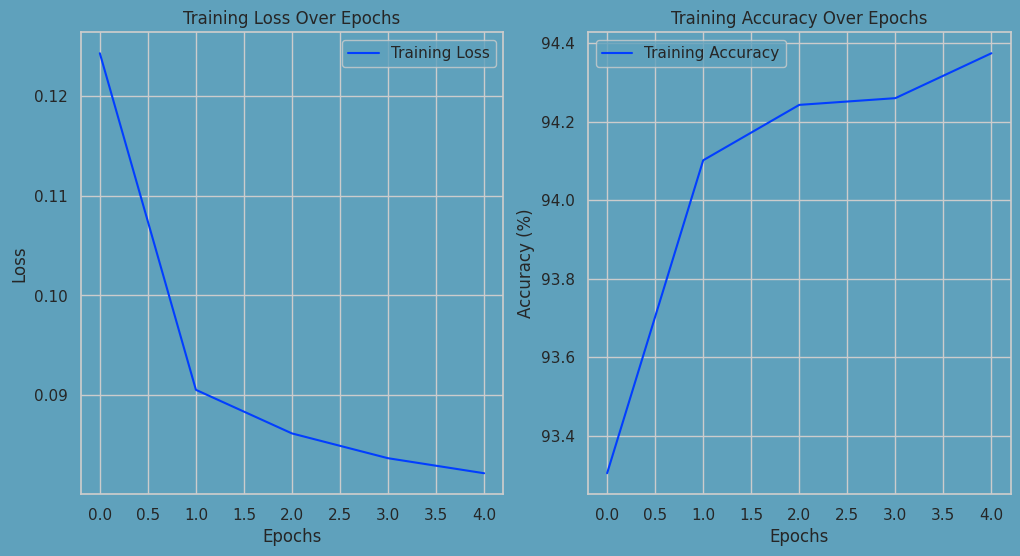

In [23]:
import matplotlib.pyplot as plt

# Assuming train_loss and train_accuracy are the outputs from the train_model function
train_loss, train_accuracy = train_model(model, train_dataloader, optimizer, device, epochs=5)

# Plotting training loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()


In [24]:
def evaluate_model(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():  # No gradients needed for evaluation, reduces memory usage
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)

    average_loss = total_loss / len(dataloader)
    accuracy = total_correct / total_samples
    return average_loss, accuracy


In [26]:
test_loss, test_accuracy = evaluate_model(model, test_dataloader, device)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}%")


Test Loss: 0.0936
Test Accuracy: 0.9423%


In [27]:
def predict_model(model, dataloader, device):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            logits = outputs.logits
            batch_predictions = torch.argmax(logits, dim=-1)

            predictions.extend(batch_predictions.cpu().numpy())  # Move predictions to CPU and convert to numpy
            true_labels.extend(labels.cpu().numpy())  # Move true labels to CPU and convert to numpy

    return predictions, true_labels


In [28]:
predictions, true_labels = predict_model(model, test_dataloader, device)

In [37]:
from sklearn.metrics import f1_score,roc_auc_score,r2_score

f1 = f1_score(true_labels, predictions, average='micro')
print("F1-Score:", f1)
r2 = r2_score(true_labels, predictions)
print("R² Score:", r2)

F1-Score: 0.9422769600480625
R² Score: 0.8859511999326666


In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(predictions, true_labels, classes):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt="d", cbar=False, cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

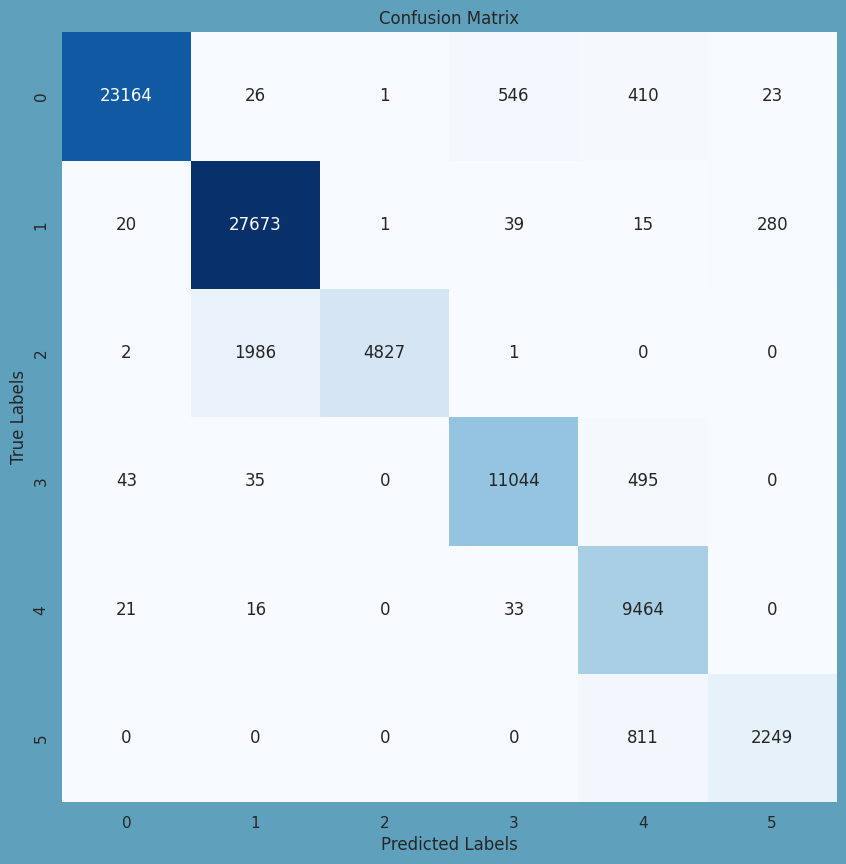

In [30]:
classes = [0,1,2,3,4,5]  # Replace with your actual class names

# Now call the plotting function
plot_confusion_matrix(predictions, true_labels, classes)

BiLSTM - 64units

In [35]:
tokenizer = Tokenizer(num_words=60000)
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)

In [36]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [37]:
maxlen = max(len(tokens) for tokens in X_train_sequences)
print("Maximum sequence length (maxlen):", maxlen)

Maximum sequence length (maxlen): 79


In [38]:
X_train_padded = pad_sequences(X_train_sequences, maxlen=maxlen, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=maxlen, padding='post')

In [39]:
print("X_train_padded:")
print(X_train_padded)
print("\nX_test_padded:")
print(X_test_padded)

X_train_padded:
[[  156   369    10 ...     0     0     0]
 [   95     2    73 ...     0     0     0]
 [    1     3    32 ...     0     0     0]
 ...
 [  625    91   103 ...     0     0     0]
 [  172   600 18035 ...     0     0     0]
 [  737     1  3864 ...     0     0     0]]

X_test_padded:
[[  51    1  171 ...    0    0    0]
 [ 207  231 2140 ...    0    0    0]
 [  15    2    4 ...    0    0    0]
 ...
 [ 487   89  626 ...    0    0    0]
 [  95    2 1325 ...    0    0    0]
 [ 224  420    1 ...    0    0    0]]


In [40]:
y_train.shape

(332898,)

In [41]:
input_size = np.max(X_train_padded) + 1
input_size

60000

In [46]:
model = Sequential()

# Add an embedding layer
model.add(Embedding(input_dim=input_size, output_dim=100,input_shape=(79,)))

# Add a bidirectional GRU layer with 128 units
model.add(Bidirectional(LSTM(64)))

# Add batch normalization layer
model.add(BatchNormalization())

# Add dropout regularization
model.add(Dropout(0.5))

# Add a dense layer with 64 units and ReLU activation
model.add(Dense(64, activation='relu'))

# Add dropout regularization
model.add(Dropout(0.5))

# Add the output layer with 6 units for 6 labels and softmax activation
model.add(Dense(6, activation='softmax'))

In [47]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 79, 100)           6000000   
                                                                 
 bidirectional (Bidirection  (None, 128)               84480     
 al)                                                             
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [48]:
history = model.fit(X_train_padded, y_train, epochs=10, batch_size=32, validation_data=(X_test_padded, y_test),callbacks=[EarlyStopping(patience=3)])

Epoch 1/10
10404/10404 [==============================] - 146s 13ms/step - loss: 0.2516 - accuracy: 0.8979 - val_loss: 0.1023 - val_accuracy: 0.9363
Epoch 2/10
10404/10404 [==============================] - 115s 11ms/step - loss: 0.1130 - accuracy: 0.9359 - val_loss: 0.0940 - val_accuracy: 0.9391
Epoch 3/10
10404/10404 [==============================] - 113s 11ms/step - loss: 0.1031 - accuracy: 0.9384 - val_loss: 0.1034 - val_accuracy: 0.9401
Epoch 4/10
10404/10404 [==============================] - 114s 11ms/step - loss: 0.0985 - accuracy: 0.9395 - val_loss: 0.0936 - val_accuracy: 0.9405
Epoch 5/10
10404/10404 [==============================] - 111s 11ms/step - loss: 0.0956 - accuracy: 0.9405 - val_loss: 0.0957 - val_accuracy: 0.9400
Epoch 6/10
10404/10404 [==============================] - 111s 11ms/step - loss: 0.0931 - accuracy: 0.9415 - val_loss: 0.0992 - val_accuracy: 0.9404
Epoch 7/10
10404/10404 [==============================] - 111s 11ms/step - loss: 0.0919 - accuracy: 0.9418

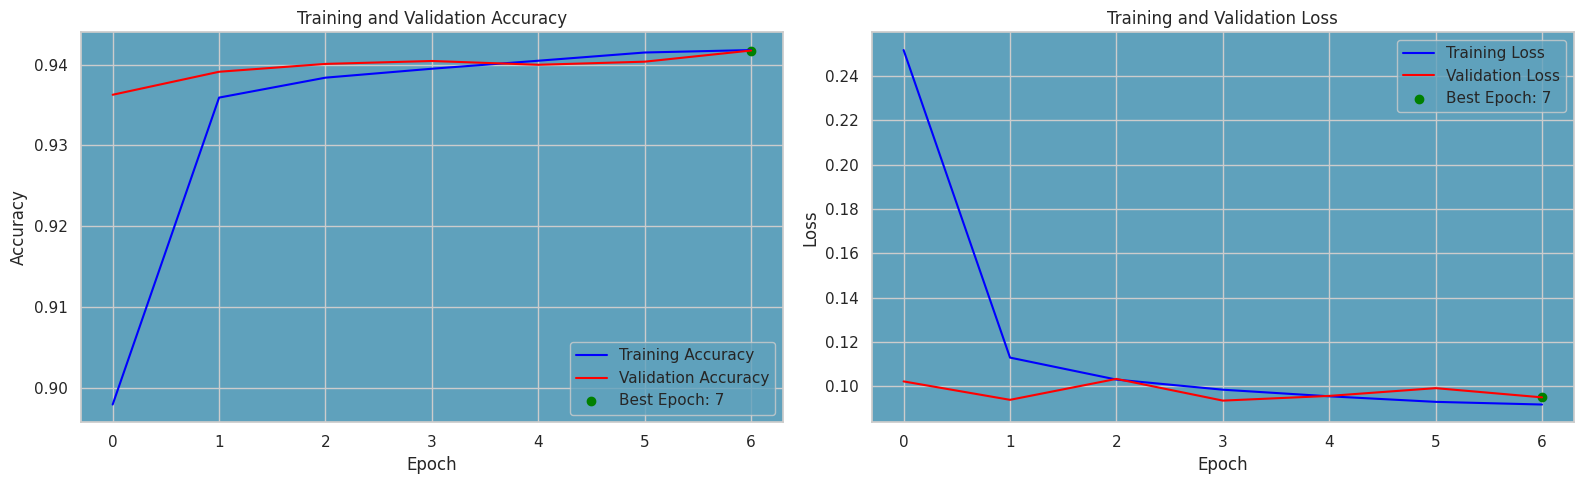

In [49]:
# Set the background color and theme
background_color = '#5fa1bc'
sns.set_theme(style="whitegrid", rc={"axes.facecolor": background_color})

# Get the epoch with the highest validation accuracy
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1

# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Plot training and validation accuracy
axs[0].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
axs[0].scatter(best_epoch - 1, history.history['val_accuracy'][best_epoch - 1], color='green', label=f'Best Epoch: {best_epoch}')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend()

# Plot training and validation loss
axs[1].plot(history.history['loss'], label='Training Loss', color='blue')
axs[1].plot(history.history['val_loss'], label='Validation Loss', color='red')
axs[1].scatter(best_epoch - 1, history.history['val_loss'][best_epoch - 1], color='green',label=f'Best Epoch: {best_epoch}')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

In [50]:
model.evaluate(X_test_padded, y_test)

2601/2601 [==============================] - 11s 4ms/step - loss: 0.0951 - accuracy: 0.9417


[0.095094695687294, 0.9417482614517212]

In [51]:
y_pred = model.predict(X_test_padded)
y_pred = np.argmax(y_pred, axis=1)

2601/2601 [==============================] - 10s 4ms/step


In [53]:
from sklearn.metrics import f1_score,roc_auc_score,r2_score

f1 = f1_score(y_test, y_pred, average='micro')
print("F1-Score:", f1)
r2 = r2_score(y_test, y_pred)
print("R² Score:", r2)

F1-Score: 0.941748272754581
R² Score: 0.8805379421185591


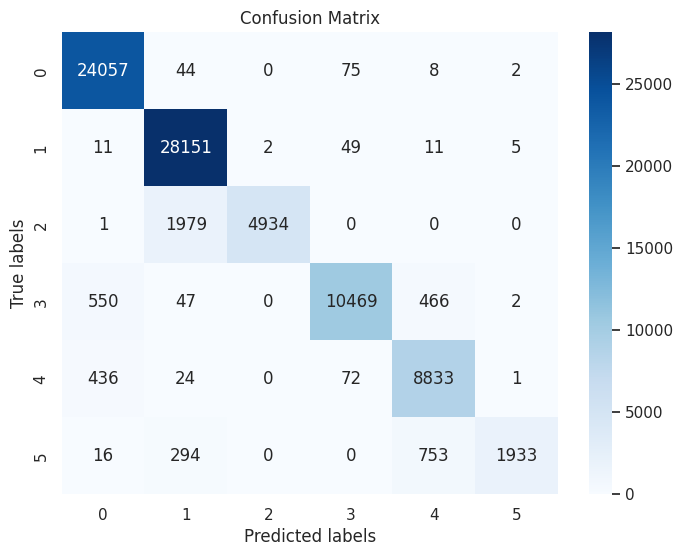

In [52]:
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix with blue color
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')  # Change 'Reds' to 'Blues' for blue color
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

BiLSTM - 2 dense layers

In [42]:
model = Sequential()

model.add(Embedding(input_dim=input_size, output_dim=100,input_shape=(79,)))
model.add(Bidirectional(LSTM(64)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

In [43]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 79, 100)           6000000   
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               84480     
 onal)                                                           
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dropout_4 (Dropout)         (None, 64)               

In [44]:
history = model.fit(X_train_padded, y_train, epochs=10, batch_size=32, validation_data=(X_test_padded, y_test),callbacks=[EarlyStopping(patience=3)])

Epoch 1/10
10404/10404 [==============================] - 146s 13ms/step - loss: 0.4854 - accuracy: 0.8136 - val_loss: 0.1520 - val_accuracy: 0.9355
Epoch 2/10
10404/10404 [==============================] - 115s 11ms/step - loss: 0.2475 - accuracy: 0.8987 - val_loss: 0.1277 - val_accuracy: 0.9374
Epoch 3/10
10404/10404 [==============================] - 114s 11ms/step - loss: 0.2218 - accuracy: 0.9089 - val_loss: 0.1331 - val_accuracy: 0.9361
Epoch 4/10
10404/10404 [==============================] - 113s 11ms/step - loss: 0.2095 - accuracy: 0.9134 - val_loss: 0.1311 - val_accuracy: 0.9371
Epoch 5/10
10404/10404 [==============================] - 113s 11ms/step - loss: 0.2032 - accuracy: 0.9162 - val_loss: 0.1328 - val_accuracy: 0.9350


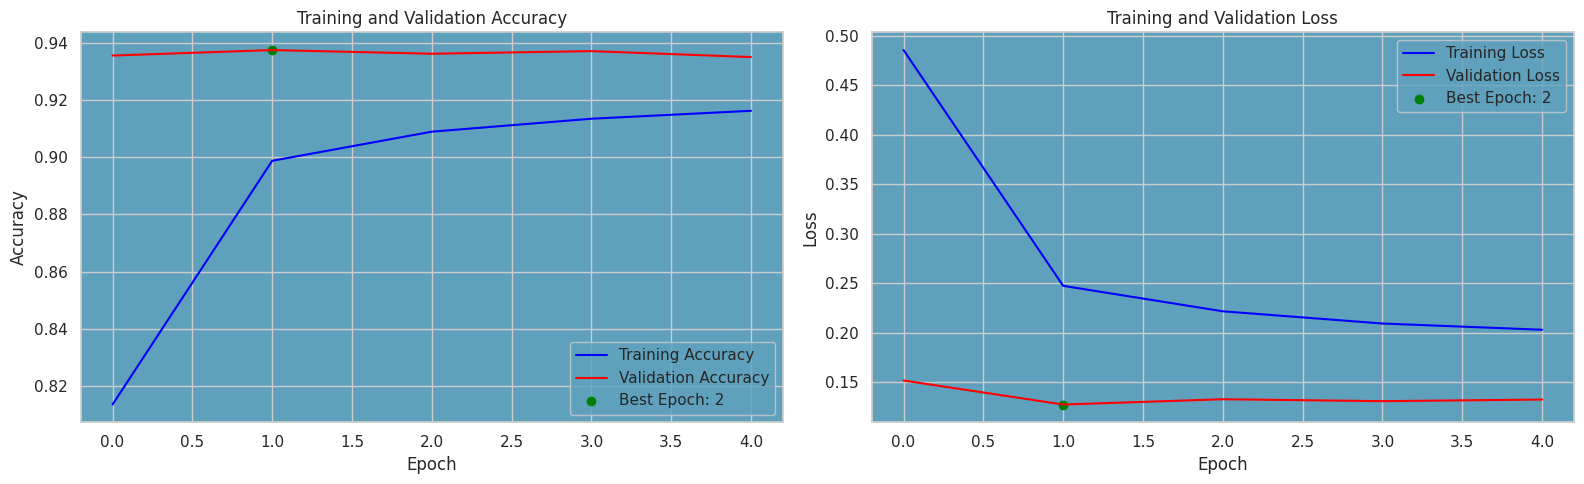

In [45]:
# Set the background color and theme
background_color = '#5fa1bc'
sns.set_theme(style="whitegrid", rc={"axes.facecolor": background_color})

# Get the epoch with the highest validation accuracy
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1

# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Plot training and validation accuracy
axs[0].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
axs[0].scatter(best_epoch - 1, history.history['val_accuracy'][best_epoch - 1], color='green', label=f'Best Epoch: {best_epoch}')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend()

# Plot training and validation loss
axs[1].plot(history.history['loss'], label='Training Loss', color='blue')
axs[1].plot(history.history['val_loss'], label='Validation Loss', color='red')
axs[1].scatter(best_epoch - 1, history.history['val_loss'][best_epoch - 1], color='green',label=f'Best Epoch: {best_epoch}')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

In [46]:
model.evaluate(X_test_padded, y_test)

2601/2601 [==============================] - 11s 4ms/step - loss: 0.1328 - accuracy: 0.9350


[0.1327667534351349, 0.934983491897583]

In [48]:
y_pred = model.predict(X_test_padded)
y_pred = np.argmax(y_pred, axis=1)

2601/2601 [==============================] - 10s 4ms/step


In [50]:
from sklearn.metrics import f1_score,roc_auc_score,r2_score

f1 = f1_score(y_test, y_pred, average='micro')
print("F1-Score:", f1)
r2 = r2_score(y_test, y_pred)
print("R² Score:", r2)

F1-Score: 0.9349834785220787
R² Score: 0.87049921455169


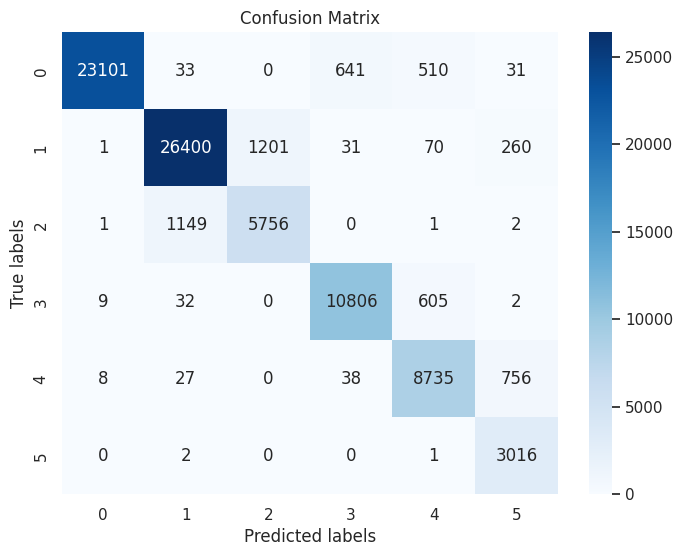

In [51]:
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix with blue color
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')  # Change 'Reds' to 'Blues' for blue color
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()